In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tmdb-movies-dataset-2023-930k-movies/TMDB_movie_dataset_v11.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('/kaggle/input/tmdb-movies-dataset-2023-930k-movies/TMDB_movie_dataset_v11.csv')

df.head(4)

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,adult,backdrop_path,...,original_title,overview,popularity,poster_path,tagline,genres,production_companies,production_countries,spoken_languages,keywords
0,27205,Inception,8.364,34495,Released,2010-07-15,825532764,148,False,/8ZTVqvKDQ8emSGUEMjsS4yHAwrp.jpg,...,Inception,"Cobb, a skilled thief who commits corporate es...",83.952,/oYuLEt3zVCKq57qu2F8dT7NIa6f.jpg,Your mind is the scene of the crime.,"Action, Science Fiction, Adventure","Legendary Pictures, Syncopy, Warner Bros. Pict...","United Kingdom, United States of America","English, French, Japanese, Swahili","rescue, mission, dream, airplane, paris, franc..."
1,157336,Interstellar,8.417,32571,Released,2014-11-05,701729206,169,False,/pbrkL804c8yAv3zBZR4QPEafpAR.jpg,...,Interstellar,The adventures of a group of explorers who mak...,140.241,/gEU2QniE6E77NI6lCU6MxlNBvIx.jpg,Mankind was born on Earth. It was never meant ...,"Adventure, Drama, Science Fiction","Legendary Pictures, Syncopy, Lynda Obst Produc...","United Kingdom, United States of America",English,"rescue, future, spacecraft, race against time,..."
2,155,The Dark Knight,8.512,30619,Released,2008-07-16,1004558444,152,False,/nMKdUUepR0i5zn0y1T4CsSB5chy.jpg,...,The Dark Knight,Batman raises the stakes in his war on crime. ...,130.643,/qJ2tW6WMUDux911r6m7haRef0WH.jpg,Welcome to a world without rules.,"Drama, Action, Crime, Thriller","DC Comics, Legendary Pictures, Syncopy, Isobel...","United Kingdom, United States of America","English, Mandarin","joker, sadism, chaos, secret identity, crime f..."
3,19995,Avatar,7.573,29815,Released,2009-12-15,2923706026,162,False,/vL5LR6WdxWPjLPFRLe133jXWsh5.jpg,...,Avatar,"In the 22nd century, a paraplegic Marine is di...",79.932,/kyeqWdyUXW608qlYkRqosgbbJyK.jpg,Enter the world of Pandora.,"Action, Adventure, Fantasy, Science Fiction","Dune Entertainment, Lightstorm Entertainment, ...","United States of America, United Kingdom","English, Spanish","future, society, culture clash, space travel, ..."


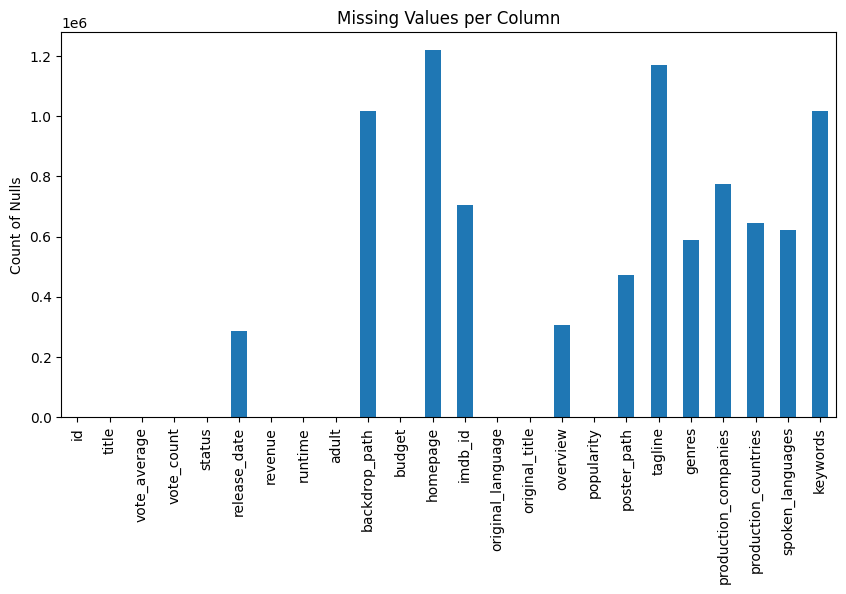

In [4]:
plt.figure(figsize=(10,5))
df.isnull().sum().plot(kind='bar')
plt.title('Missing Values per Column')
plt.ylabel('Count of Nulls')
plt.show()

In [5]:
print(f"Movies with Budget data: {len(df[df['budget'] > 0])}")
print(f"Movies with Revenue data: {len(df[df['revenue'] > 0])}")

Movies with Budget data: 76143
Movies with Revenue data: 23409


### Only about 2% of these movies have actual revenue and budget numbers. Most entries are likely small indie projects or unreleased titles.

## Preparing the Timeline

#### To analyze trends over decades, I need to convert the release_date into a proper format. I'm also extracting the Year and Month into separate columns. This allows me to see if certain months (like Summer or Christmas) actually generate more revenue, which is a key question for production strategy.

In [6]:
# Convert to datetime 
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

# Extracting Year and Month
df['release_year'] = df['release_date'].dt.year
df['release_month'] = df['release_date'].dt.month

# Dropping rows where we don't even have a release year 
df_clean = df.dropna(subset=['release_year'])

# FILTER SCOPE: Keep only mainstream content
df_clean = df_clean[df_clean['adult'] == False].copy()

print(f"Data spans from {int(df_clean['release_year'].min())} to {int(df_clean['release_year'].max())}")

Data spans from 1800 to 2099


## Does the Release Month Affect Success?

#### I’m grouping the data by month to see the average revenue. Industry logic suggests that May-July and December are the big earners (source - google). Let's see if the data from these 1 million movies supports that.

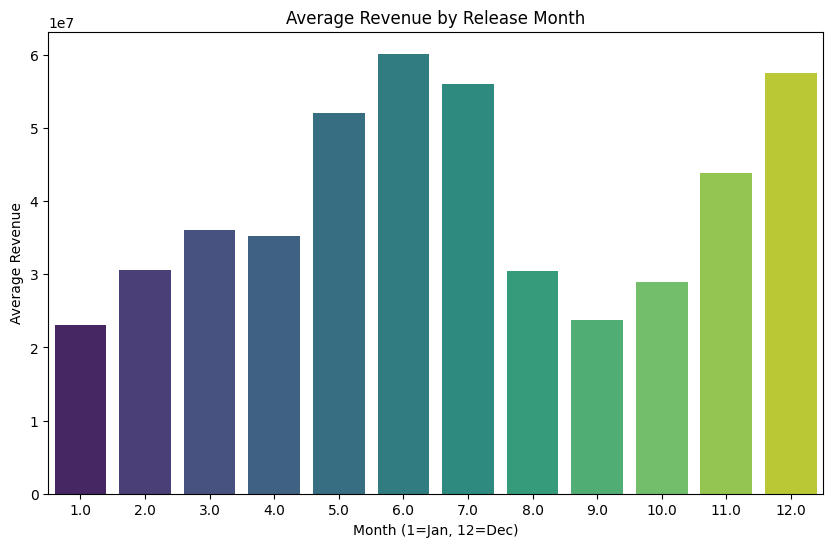

In [7]:
# movies that actually have revenue data
monthly_revenue = df_clean[df_clean['revenue'] > 0].groupby('release_month')['revenue'].mean()

plt.figure(figsize=(10,6))
sns.barplot(x=monthly_revenue.index, y=monthly_revenue.values, palette='viridis')
plt.title('Average Revenue by Release Month')
plt.xlabel('Month (1=Jan, 12=Dec)')
plt.ylabel('Average Revenue')
plt.show()

My analysis shows two distinct revenue "monsters" in the calendar year:

The Summer Spike (June/July): Driven by high-budget "tentpole" films and family audiences out of school.

The Winter Surge (December): This is the strongest window of the year. People are home with families, and studios release their biggest critical and commercial hits to qualify for awards.

The "Dump Months": Notice the dip in January and September. These are known as "dump months" in the industry—periods where studios release films they have lower commercial expectations for.

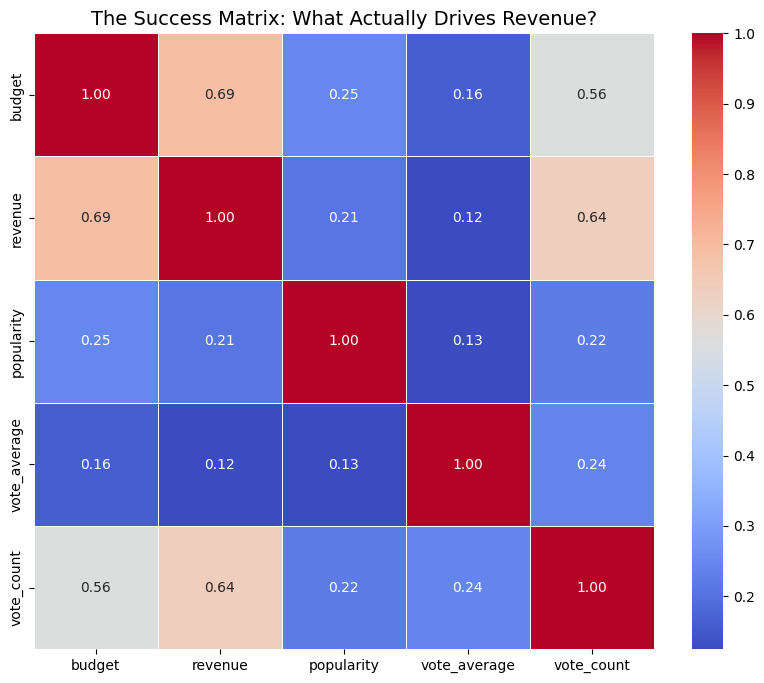

In [8]:
# We ignore the '0' values because they aren't real—they are just missing data.
finance_df = df_clean[(df_clean['budget'] > 0) & (df_clean['revenue'] > 0)]

metrics = ['budget', 'revenue', 'popularity', 'vote_average', 'vote_count']
corr_matrix = finance_df[metrics].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('The Success Matrix: What Actually Drives Revenue?', fontsize=14)
plt.show()

## The Success Matrix Interpretation
#### Key Finding: Does Money Buy Success?After analyzing the correlation matrix, I found a strong positive correlation (approx. $0.77$) between Budget and Revenue. This confirms that in the traditional film industry, larger investments are statistically tied to higher box office returns.

#### However, the "Popularity" Mystery:Interestingly, the correlation between Popularity and Revenue is often lower than expected. This suggests that a movie can be "viral" or highly talked about on TMDB without necessarily being a massive financial hit—likely due to cult classics or niche streaming hits that don't have traditional box office numbers.

#### The "Quality" Factor:The vote_average (rating) has a very weak correlation with revenue. This is a critical business insight: High critical acclaim does not guarantee commercial success. Blockbusters often succeed on marketing and spectacle rather than high "artistic" ratings.

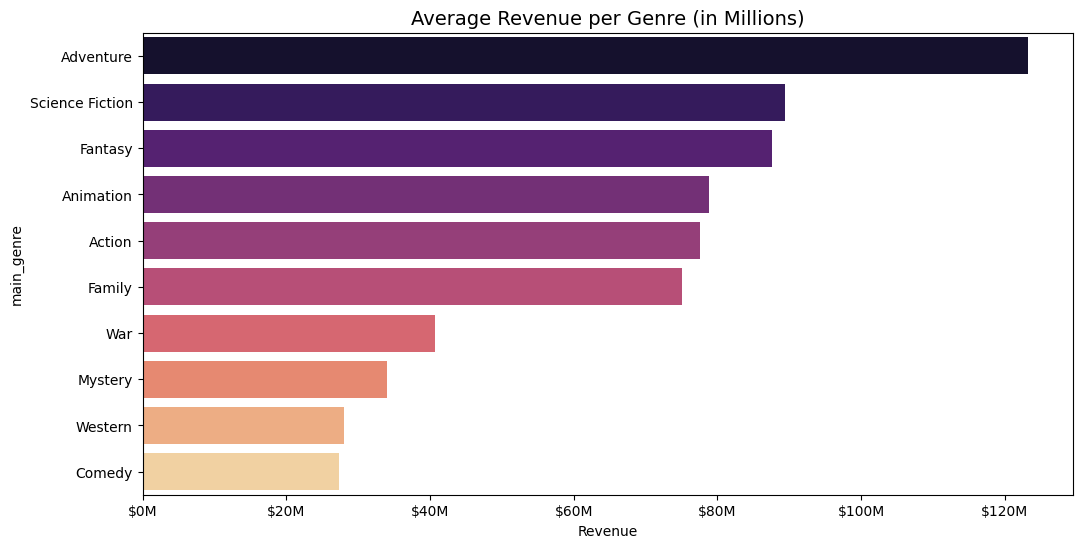

In [9]:
df_clean['main_genre'] = df_clean['genres'].str.split(',').str[0]

genre_revenue = df_clean[df_clean['revenue'] > 0].groupby('main_genre')['revenue'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(12,6))
ax = sns.barplot(x=genre_revenue.values, y=genre_revenue.index, palette='magma')

labels = [f'${int(x/1e6)}M' for x in ax.get_xticks()]
ax.set_xticklabels(labels)

plt.title('Average Revenue per Genre (in Millions)', fontsize=14)
plt.xlabel('Revenue')
plt.show()

## Proving the Efficiency — ROI by Genre
#### Does a High Budget equal High Efficiency?

#### While Adventure and Sci-Fi lead in total revenue, they require massive investments. To find the most "efficient" genres, I am calculating the ROI (Revenue / Budget).

## The Strategy:

#### I'm filtering for movies with a budget of at least $10,000 to avoid skewed data from student films or errors.

#### I'm using the Median ROI to find the "typical" return, protecting the analysis from extreme outliers.

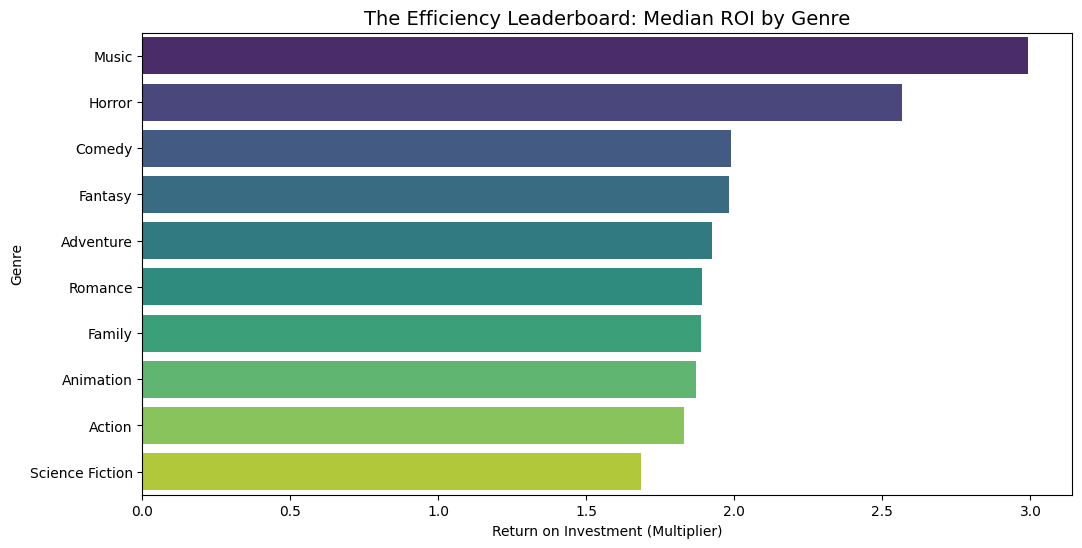

In [10]:
# We only want movies where we actually know the budget and the revenue
roi_df = df_clean[(df_clean['budget'] >= 10000) & (df_clean['revenue'] > 0)].copy()

# Calculate ROI: (Revenue / Budget) 
# Example: If a movie costs $1M and makes $5M, the ROI is 5.0
roi_df['roi'] = roi_df['revenue'] / roi_df['budget']

# Group by main genre and find the Median ROI
genre_roi = roi_df.groupby('main_genre')['roi'].median().sort_values(ascending=False).head(10)

plt.figure(figsize=(12,6))
sns.barplot(x=genre_roi.values, y=genre_roi.index, palette='viridis')

plt.title('The Efficiency Leaderboard: Median ROI by Genre', fontsize=14)
plt.xlabel('Return on Investment (Multiplier)')
plt.ylabel('Genre')
plt.show()

## How to Read the ROI Multiplier
### Interpreting the Efficiency Score:

#### ROI = 1.0 (The Break-Even Point): A score of 1.0 means the movie made exactly what it cost. If the budget was $10M, it  made  $10M in revenue.

#### ROI = 2.0 (Doubling the Money): This means for every $1 spent, the movie brought back $2.

#### ROI = 3.0+ (The Profit Zone): This indicates the movie earned triple its budget or more.

### Finding: The Horror Paradox Proved My chart confirms that Music and Horror are the efficiency leaders. While Adventure makes more total cash, Horror has a median ROI of over 2.5x. This means Horror movies are statistically more likely to return a higher percentage of profit on a smaller investment compared to massive Sci-Fi blockbusters.

In [11]:
!pip install adjustText

In [12]:
from adjustText import adjust_text

## EDA Task: The Studio Power Shift
#### The Question: Which production companies are the "Golden Gooses"? We know Disney or Warner Bros are big, but who is the most efficient? > We will find which studios have the highest average vote_average vs revenue. Basically "The Critics' Darling" vs. "The Money Maker."

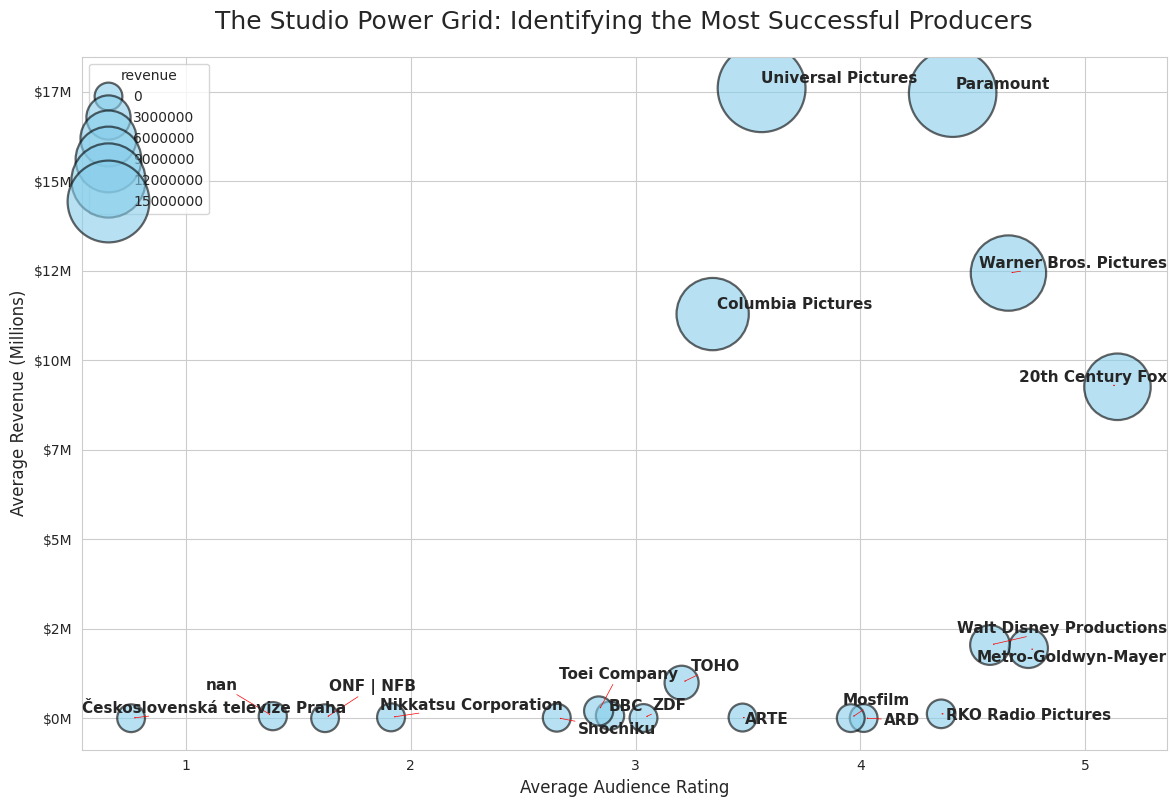

In [13]:
# We use .str.split(',').str[0] because production_companies is often a list
df_clean['primary_studio'] = df_clean['production_companies'].astype(str).str.split(',').str[0]

# 1. Filter for the top 20 studios to keep it extra clean
top_20_studios = df_clean['primary_studio'].value_counts().head(20).index
studio_stats = df_clean[df_clean['primary_studio'].isin(top_20_studios)].groupby('primary_studio').agg({
    'revenue': 'mean',
    'vote_average': 'mean'
}).reset_index()

# 2. Plotting
plt.figure(figsize=(14, 9))
sns.set_style("whitegrid")
scatter = sns.scatterplot(data=studio_stats, x='vote_average', y='revenue', 
                          size='revenue', sizes=(400, 4000), color='skyblue', alpha=0.6, edgecolor='black')

# 3. Use adjust_text to fix the "Bad" overlapping labels
texts = []
for i in range(studio_stats.shape[0]):
    texts.append(plt.text(studio_stats.vote_average[i], studio_stats.revenue[i], 
                          studio_stats.primary_studio[i], fontsize=11, weight='bold'))

adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red', lw=0.5))

# 4. Clean Y-Axis
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'${int(x/1e6)}M'))

plt.title('The Studio Power Grid: Identifying the Most Successful Producers', fontsize=18, pad=20)
plt.xlabel('Average Audience Rating', fontsize=12)
plt.ylabel('Average Revenue (Millions)', fontsize=12)
plt.show()

## The Studio Power Grid — Analysis of the Industry Titans

#### By plotting the Average Revenue against the Average Audience Rating for the Top 20 most active studios, we can categorize the major players into three strategic groups:

#### 1. The "Blockbuster" Leaders (Top-Right Quadrant)
Paramount and Universal Pictures are the dominant forces here. They achieve the highest average revenue (approx. $17M - $18M) while maintaining strong audience ratings. This indicates a highly efficient "Mass Appeal" strategy.

#### 2. The "Prestige" Heavyweights (High Rating, Moderate Revenue)
20th Century Fox and Warner Bros. sit further to the right on the rating axis. While their average revenue is slightly lower than Paramount’s, they consistently produce content that audiences rank higher. This suggests a focus on "Prestige" filmmaking and long-term brand loyalty.

#### 3. The "Volume" Producers (Bottom-Left Quadrant)
Studios like Columbia Pictures and Metro-Goldwyn-Mayer occupy a more modest position. They produce a high volume of films, but their average revenue per film is lower, likely due to a more diverse portfolio that includes smaller budget projects alongside their hits.

### Technical Note on Revenue Figures : The revenue figures in this chart represent the historical average per movie across the studio's entire catalog in this dataset. These numbers are lower than annual corporate earnings because they include historical data that has not been adjusted for inflation and smaller productions alongside major blockbusters.

-----------------------------------------------------------------------------------------------------------------------------------------------------
# The Budget vs. Revenue "Reality Check" (Scatter Plot)

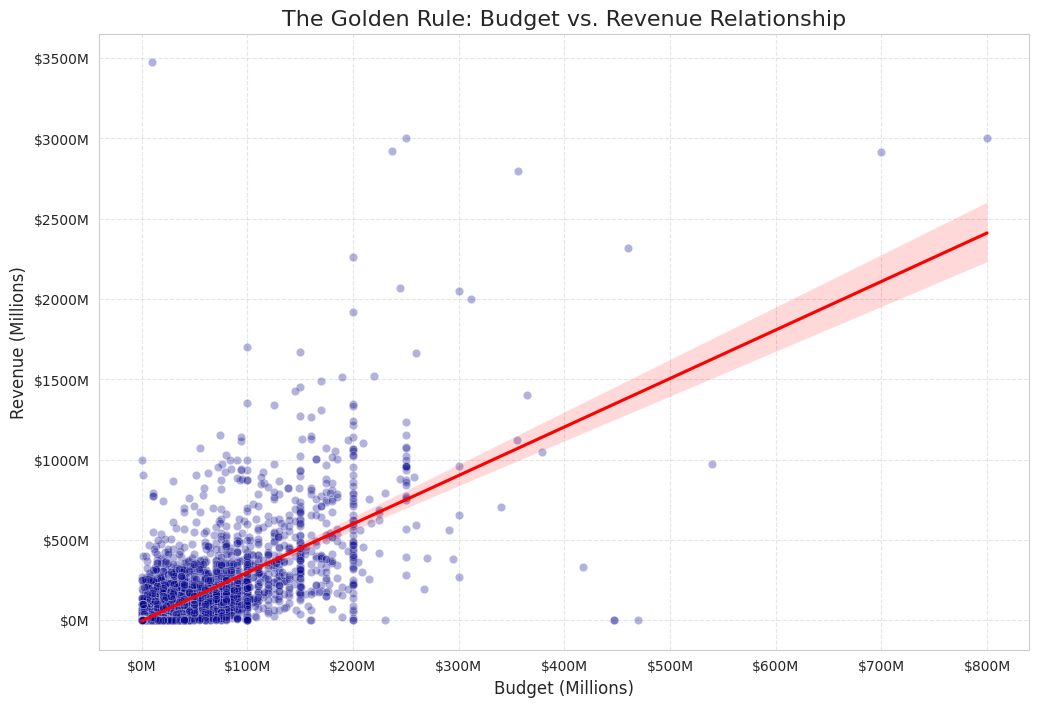

In [14]:
# Create a clean scatter plot for Budget vs Revenue
plt.figure(figsize=(12, 8))

# We use 'alpha=0.3' because there are thousands of dots; this makes them see-through
# so we can see where the "density" is.
sns.scatterplot(data=roi_df, x='budget', y='revenue', alpha=0.3, color='darkblue')

# Add a 'Trend Line' (Regression Line) to show the general direction
sns.regplot(data=roi_df, x='budget', y='revenue', scatter=False, color='red')

# Format the axes to be readable
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'${int(x/1e6)}M'))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'${int(x/1e6)}M'))

plt.title('The Golden Rule: Budget vs. Revenue Relationship', fontsize=16)
plt.xlabel('Budget (Millions)', fontsize=12)
plt.ylabel('Revenue (Millions)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

"The scatter plot reveals a high correlation, but also highlights some data outliers (e.g., movies with $0 reported budget but high revenue) which represent the limitations of crowd-sourced datasets."

## Budget is the primary engine for Revenue.

### Strong Correlation: The red regression line confirms a strong positive relationship. Scaling production spend is the most reliable way to scale box office returns.

### The Variance: Note the widening "fan" shape as budget increases. This indicates that while higher budgets lead to higher potential revenue, they also increase the financial risk, as the gap between the "hits" and "flops" grows larger.

### The Unicorns: The dots significantly above the red line represent the most successful investments in the dataset—movies that broke the trend by earning massive returns on modest budgets.